In [1]:
import matplotlib.pyplot as plt
import pygame
import numpy as np
import random
import copy
import cma

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
##### CONSTANTES
N_in = 40*40 + 2 + 2
N1 = 3
N2 = 3
N_out = 2
f = 0.3
rb = 1
rt = 20
m = 1
g = 9.81
k = 2
ratio_distance = 600
ratio_angle = 100


num_elites = 3
nbre_mouvements = 50
nb_gen = 20
nb_pop = 100
mutation_rate = 2/(nbre_mouvements*2)
v_max = 10

In [3]:
###### FONCTIONS UTILES

def produitvectoriel(vect1,vect2):
    return (vect1[0]*vect2[1] - vect1[1]*vect2[0])

def produitscalaire(vect1,vect2):
    return(vect1[0]*vect2[0] + vect1[1]*vect2[1])

def draw_circle(matrice,i,j,r, colour):
    for x in range(len(matrice)):
        for y in range(len(matrice[x])):
            if abs((x-i)**2 + (y-j)**2) <=r**2:
                matrice[x,y] = colour

def get_line(start, end):
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
    is_steep = abs(dy) > abs(dx)
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
    dx = x2 - x1
    dy = y2 - y1
    error = int(dx / 0.5)
    ystep = 1 if y1 < y2 else -1
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
    if swapped:
        points.reverse()
    return points


def draw_segment(matrice, start,end):
    points = get_line(start, end)
    shape = np.shape(matrice)
    for i in points:
        if i[0]<shape[0] and i[1] < shape[1]:
            matrice[i[0],i[1]] = 0.7
        


In [20]:
##### CLASSE JOUEUR
class Joueur:  
    def __init__(self, array_trou,array_balle,obstacles, nbre_mouvements):
        self.is_best = False
        self.fitness = 0
        self.partie = Partie(array_balle,array_trou,obstacles)
        self.liste_mouvements = []
        self.liste_emplacements = [array_balle]
        self.nn = Simple_nn(N_in,N1,N_out)
        for i in range(nbre_mouvements):
            v = random.random()*v_max
            t = random.random()*2*np.pi
            self.liste_mouvements.append([v,t])
            
    def evaluate_fitness(self):
        distance = np.sqrt((self.partie.trou.position[0] - self.partie.balle.position[0])**2 + (self.partie.trou.position[1] - self.partie.balle.position[1])**2 ) 
        if self.partie.reached_goal:
            print("victoire")
            self.fitness = 3 + 10/(self.partie.nb_coups**2)
        elif (not self.partie.is_dead): 
            self.fitness = self.partie.nb_coups/distance**2 
        else:
            self.fitness = -5/self.partie.nb_coups
        return float(self.fitness)
            
        
    def faire_partie(self):
        self.partie = Partie(array_balle,array_trou,obstacles)
        for i in range(20):
            print(i)
            if self.partie.is_dead:
                self.evaluate_fitness()
                print(self.partie.is_dead)
                return
            else:
                array = self.partie.matrice[int(self.partie.balle.position[0]) -20:int(self.partie.balle.position[0]) +20,int(self.partie.balle.position[1]) -20:int(self.partie.balle.position[1]) +20].flatten()
                b = np.array([self.partie.balle.position[0],self.partie.balle.position[1],self.partie.trou.position[0],self.partie.trou.position[1]]) 
                #print(array)
                #print(b)
                c = np.concatenate((array, b)).flatten()
                self.liste_mouvements.append(self.nn.compute(c))
                a = self.partie.deplacement(self.liste_mouvements[-1])
                self.liste_emplacements.append(a)
                self.partie.remplir_matrice()
            print(self.partie.balle.position)
        print(self.partie.is_dead)
        self.evaluate_fitness()
        return
        
        
    
                

In [21]:
###### CLASSE NEURAL NETWORK
class Simple_nn:
    def __init__(self, N_in, N1,N_out):
        self.fitness = 0
        self.l1 = np.random.random((N_in,N1))
        self.l2 = np.random.random((N1,N2))
        self.out = np.random.random((N2,N_out))
    
    def compute(self,inputs):
        x = np.dot(self.l1,np.reshape(inputs,(N_in,1)))
        x = np.dot(self.l2, x)
        x = np.dot(self.out,x)
        x = x/(N_in*N1)
        return (x.flatten())
    
    def transform(self, genes):
        layers = [self.l1.flatten(),self.l2.flatten(),self.out.flatten()]
        L = 0
        j = 0
        for i in range(len(genes)):
            if j >= len(layers[L]):
                L += 1
                j = 0
            layers[L][j] = genes[i]
            j += 1
        self.l1 = np.reshape(np.asmatrix(layers[0]),(N1,N_in))
        self.l2 = np.reshape(np.asmatrix(layers[1]),(N2,N1))
        self.out = np.reshape(np.asmatrix(layers[2]),(N_out,N2))  

In [22]:
#### CLASSE SEGMENT

class Segment:
    def __init__(self,array1,array2):
        self.depart = array1
        self.arrivee = array2
        
    def cross(self , segment):
        ab = [self.arrivee[0] - self.depart[0] , self.arrivee[1] - self.depart[1]]
        apbp = [segment.arrivee[0] - segment.depart[0] , segment.arrivee[1] - segment.depart[1]]
        abp = [segment.arrivee[0] - self.depart[0], segment.arrivee[1] - self.depart[1]]
        aap = [segment.depart[0] - self.depart[0], segment.depart[1] - self.depart[1] ]
        apb = [self.arrivee[0] - segment.depart[0] , self.arrivee[1] - segment.depart[1]]
        apa = [self.depart[0] - segment.depart[0] , self.depart[1] - segment.depart[1]]
        
        c1 = produitvectoriel(ab,apbp) != 0
        c2 = (produitvectoriel(ab,abp) * produitvectoriel(ab,aap))<=0
        c3 = (produitvectoriel(apbp,apb) * produitvectoriel(apbp,apa))<=0
        return(c1 and c2 and c3)

In [23]:
##### CLASSE TROU

class Trou:
    def __init__(self, array):
        self.position = array.copy()
 

In [24]:
##### CLASSE BALLE

class Balle:
    def __init__(self, array):
        self.position = array.copy()

In [25]:
##### CLASSE PARTIE

class Partie:
    def __init__(self, arrayballe,arraytrou, obstacles):
        self.matrice = np.zeros((800,800),dtype = float)
        self.balle = Balle(arrayballe)
        self.trou = Trou(arraytrou)
        self.obstacles = obstacles
        self.is_dead = False
        self.nb_coups = 1
        self.reached_goal = False 
        
    def is_won(self):
        distance = np.sqrt((self.trou.position[0] - self.balle.position[0])**2 + (self.trou.position[1] - self.balle.position[1])**2 )
       # print(distance)
        if distance < rt :
            self.reached_goal = True
    
    def is_possible_move(self,segment_dep):
        liste_obstacles_cross = []
        for i in self.obstacles: # Pour tous les obstacles
            if i.cross(segment_dep): # Si un segment_dep et i se croisent alors le move n'est pas possible
                    liste_obstacles_cross.append(i)
        if len(liste_obstacles_cross) > 0 :
            liste_distances = []
            liste_inter = []
            for i in liste_obstacles_cross:
                if (segment_dep.depart[0] - segment_dep.arrivee[0] == 0):
                    a_i = (i.depart[1] - i.arrivee[1]) / (i.depart[0] - i.arrivee[0])
                    b_i = i.depart[1] - a_i *i.depart[0]
                    x_inter = segment_dep.depart[0]
                    y_inter = a_i * x_inter + b_i
                    liste_inter.append([x_inter , y_inter])
                    
                    
                elif (i.depart[0] - i.arrivee[0] == 0):
                    a_segment_dep = (segment_dep.depart[1] - segment_dep.arrivee[1]) / (segment_dep.depart[0] - segment_dep.arrivee[0])
                    b_segment_dep = segment_dep.depart[1] - a_segment_dep * segment_dep.depart[0]
                    x_inter = i.depart[0]
                    y_inter = a_segment_dep * x_inter + b_segment_dep
                    liste_inter.append([x_inter , y_inter])
                
                else :
                    a_segment_dep = (segment_dep.depart[1] - segment_dep.arrivee[1]) / (segment_dep.depart[0] - segment_dep.arrivee[0])
                    b_segment_dep = segment_dep.depart[1] - a_segment_dep * segment_dep.depart[0]
                    a_i = (i.depart[1] - i.arrivee[1]) / (i.depart[0] - i.arrivee[0])
                    b_i = i.depart[1] - a_i *i.depart[0]
                    x_inter = (b_i - b_segment_dep) / (a_segment_dep - a_i)
                    y_inter = a_i * x_inter + b_i
                    liste_inter.append([x_inter , y_inter])
                
                liste_distances.append(np.sqrt( (x_inter - self.balle.position[0])**2 + (y_inter - self.balle.position[1])**2))
            self.balle.position[0] = liste_inter[liste_distances.index(min(liste_distances))][0]
            self.balle.position[1] = liste_inter[liste_distances.index(min(liste_distances))][1]
                
            return False
        return True
    
    def remplir_matrice(self):
        self.matrice = np.zeros((800,800))
        draw_circle(self.matrice, int(self.balle.position[0]),int(self.balle.position[1]),rb,1)
        draw_circle(self.matrice,int(self.trou.position[0]),int(self.trou.position[1]),rt,0.2)
        for i in obstacles:
            draw_segment(self.matrice, i.depart,i.arrivee)
        
    def deplacement(self,vitesse_initiale): # La vitesse sera de la forme [ ||v|| , theta)]
        
        distance =0.5*m/f*vitesse_initiale[0,0]**2*ratio_distance
        #print(distance)
        vitesse_initiale[0,1] = vitesse_initiale[0,1] *ratio_angle
        #print(distance)
        #print(vitesse_initiale)
        #print(vitesse_initiale[0,1])
        #print("distance : "+str(distance))
       # print(vitesse_initiale[0])
        segment_dep = Segment([self.balle.position[0],self.balle.position[1]],[self.balle.position[0] + np.cos(vitesse_initiale[0,1]) * distance,self.balle.position[1] + np.sin(vitesse_initiale[0,1]) * distance] )
        self.is_won()
        
        if self.reached_goal:
            return (self.balle.position[0],self.balle.position[1])
        if self.is_possible_move(segment_dep):
            self.nb_coups +=1
            #print([np.cos(vitesse_initiale[1]), np.sin(vitesse_initiale[1])])
            self.balle.position[0] += np.cos(vitesse_initiale[0,1]) * distance
            self.balle.position[1] += np.sin(vitesse_initiale[0,1]) * distance  
        else :
            self.is_dead = True
            #print("La balle est sur le mur")
        return (self.balle.position[0],self.balle.position[1])

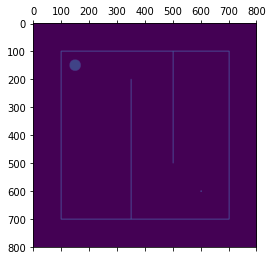

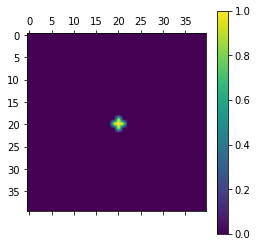

In [26]:
#DEFINITION DE LA PARTIE
obstacles = []
# On ajoute les murs
obstacles.append(Segment([100,100],[100,700]))
obstacles.append(Segment([100,100],[700,100]))
obstacles.append(Segment([100,700],[700,700]))
obstacles.append(Segment([700,100],[700,700]))
# On ajoute les obstacles
obstacles.append(Segment([100,500],[500,500]))
obstacles.append(Segment([700,350],[200,350]))
#obstacles.append(Segment([0,400],[400,400]))


array_balle = [600,600]
array_trou = [150,150]
partie = Partie(array_balle,array_trou, obstacles)

partie.remplir_matrice()
plt.figure(figsize = (800,800))
im1 = plt.matshow(partie.matrice, interpolation = 'bilinear')
a = partie.matrice[int(partie.balle.position[0]) -20:int(partie.balle.position[0]) +20,int(partie.balle.position[1]) -20:int(partie.balle.position[1]) +20]
im1 = plt.matshow(a, interpolation = 'bilinear')
plt.colorbar(im1)
plt.plot([])
plt.show()

def fitness_function(x):
    joueur = Joueur(array_trou,array_balle,obstacles, nbre_mouvements)
    joueur.nn.transform(x)
    joueur.faire_partie()
    return joueur.evaluate_fitness()
    
    

In [27]:
x0 = np.random.randn(N_in*N1+N2*N1+ N2*N_out)
es = cma.CMAEvolutionStrategy(x0,0.15)
#help(cma.CMAEvolutionStrategy)
while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [-fitness_function(x) for x in solutions])
    es.logger.add()
    es.disp()
        
        
    
        

(14_w,29)-aCMA-ES (mu_w=8.4,w_1=21%) in dimension 4827 (seed=1012144, Thu May  7 18:41:55 2020)
0
[640.3985897401961, 596.9774921002407]
1
[657.7720522351544, 640.3040737455389]
2
[618.2163409337282, 675.2226108364722]
3
[613.4777429228019, 700.0]
4
True
0
[641.7659563676289, 607.7929538874288]
1
[641.6040023739196, 657.0138015346091]
2
[588.306617481516, 672.8164787901661]
3
[578.2191904706299, 700.0]
4
True
0
[644.2148376972118, 521.1687368608772]
1
[700, 479.2799089353807]
2
True
0
[567.6307974882133, 558.6632264300234]
1
[541.9501320914336, 594.5401538142584]
2
[518.3082421647597, 631.2920840866922]
3
[493.41309608644116, 667.1483891411817]
4
[471.7862055897885, 700.0]
5
True
0
[578.970608090761, 668.8922073438862]
1
[497.2792645162543, 662.9392709686714]
2
[505.82742214848685, 700.0]
3
True
0
[573.2921610236322, 700.0]
1
True
0
[656.1402102035674, 546.265169796344]
1
[700, 552.8399185806624]
2
True
0
[618.7153810940595, 571.8448322614078]
1
[646.1632130141496, 549.8758319840217]
2

[458.4869477551483, 621.3443597239044]
14
[452.8766529246511, 633.8452667355508]
15
[447.3965736358373, 646.3525995071653]
16
[442.00907920049326, 658.8594671806372]
17
[436.68805272594557, 671.3614504979319]
18
[431.4153064134833, 683.8556533705467]
19
[427.78285428650537, 696.4424882853228]
False
0
[613.7761292101809, 624.5581740385022]
1
[609.7725677002104, 655.3966817586811]
2
[601.8142360145324, 685.7224341209294]
3
[597.855923200907, 700.0]
4
True
0
[524.1489089761337, 700.0]
1
True
0
[556.5441333055971, 681.4578662770728]
1
[538.1009283064919, 700.0]
2
True
0
[700, 578.7037080089475]
1
True
0
[676.1403720993752, 505.5941091518231]
1
[680.7058282560512, 391.0764641757048]
2
[674.5667371443267, 476.85379755522223]
3
[597.5071362734047, 403.4960261919781]
4
[668.7061557765826, 394.241472233447]
5
[680.9010689200144, 477.5500616216605]
6
[617.3153577411483, 390.13394996504735]
7
[690.0581322958833, 390.0869749804632]
8
[674.8188375324137, 475.62136395025345]
9
[595.9150547193826, 40

[601.8148194408401, 606.1703187613124]
1
[602.9644101667793, 612.2989550691799]
2
[603.9449046186929, 618.414314968959]
3
[604.7571263843205, 624.5114583022329]
4
[605.4022081367227, 630.585490603953]
5
[605.8815853170432, 636.6315850793083]
6
[606.1969877333788, 642.6450038793886]
7
[606.3504291889789, 648.6211184507534]
8
[606.3441952808657, 654.5554287519374]
9
[606.180829534453, 660.4435811516385]
10
[605.8631180602938, 666.2813848481811]
11
[605.3940729353214, 672.0648266770858]
12
[604.776914522599, 677.7900842024235]
13
[604.0150529505853, 683.4535370172827]
14
[603.9721378622019, 689.4363354219448]
15
[603.6278577072751, 695.3133942068819]
16
[602.2785411988244, 700.0]
17
True
0
[593.4026898253637, 642.1390087736906]
1
[585.8924878277028, 685.4283006403831]
2
[583.2440817033109, 700.0]
3
True
0
[604.0439864967216, 542.3439354912101]
1
[554.6810638642391, 531.1983410604919]
2
[556.394708296137, 573.4485286977686]
3
[511.3551449726392, 590.3242079112327]
4
[497.98665269722824, 63

KeyboardInterrupt: 